## Import & Load Cleaned Data

In [1]:
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(project_root)

print(f'Current working directory: {os.getcwd()}')

Current working directory: c:\Users\ibnum\Desktop\Material Learning\ML Project


In [2]:
import pandas as pd
from src.models.evaluate_model import confusion
from src.data import load_data, split_data
from src.config import config
from src.features import build_pipeline as bp, preprocessing
from src.models import build_model, evaluate_model
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [3]:
# load cleaned data from eda process
df = load_data.read_data(config.PROCESSED_PATH).drop(columns=['Unnamed: 0'])
df.head()

Data shape: (7010, 21)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [4]:
df['Churn'].value_counts(normalize=True)

Churn
0    0.735093
1    0.264907
Name: proportion, dtype: float64

## Split Train-Test Data

In [5]:
# split to train and test
X_train, X_test, y_train, y_test = split_data.split_train_test(cleaned_df=df)

X train shape: (5608, 19)
X test shape: (1402, 19)
y train shape: (5608,)
y test shape: (1402,)


## Preprocessing

In [6]:
# build the numerical and categorical pipeline
num_pipeline, cat_pipeline = bp.build_pipeline()

# build the preprocessor object
preprocessor = preprocessing.build_preprocessing(num_pipeline, cat_pipeline)

## Modeling

### Baseline Model

In [7]:
# predict baseline model
y_base_pred = build_model.build_baseline(X_train=X_train, y_train=y_train)

# evaluate baseline model
y_base_recall, y_base_precision, y_base_f1 = evaluate_model.evaluate_baseline(y_train=y_train,
                                                                              y_pred=y_base_pred)

### Predict & Evaluate CV-Train

#### LightGBM Classifier

In [8]:
# define lgb object
lgb = LGBMClassifier(random_state=config.RANDOM_STATE, verbose=config.VERBOSE)

# predict lgb model
lgb_cv_train = build_model.build_cv_train(
    estimator=lgb,
    preprocessor=preprocessor,
    params=config.LIGHTGBM_PARAMS,
    X_train=X_train,
    y_train=y_train
)

# evaluate lgb model
lgb_best_param, lgb_best_model, lgb_recall_cv, lgb_precision_cv, lgb_f1_cv, \
lgb_recall_train, lgb_precision_train, lgb_f1_train = evaluate_model.evaluate_cv_train(
    cv_model=lgb_cv_train,
    X_train=X_train,
    y_train=y_train
)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ibnum\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### XGBoost Classifier

In [9]:
# define XGB object
xgb = XGBClassifier(random_state=config.RANDOM_STATE, verbose=config.VERBOSE)

# predict XGB model
xgb_cv_train = build_model.build_cv_train(
    estimator=xgb,
    preprocessor=preprocessor,
    params=config.XGBOOST_PARAMS,
    X_train=X_train,
    y_train=y_train
)

# evaluate XGB model
xgb_best_param, xgb_best_model, xgb_recall_cv, xgb_precision_cv, xgb_f1_cv, \
xgb_recall_train, xgb_precision_train, xgb_f1_train = evaluate_model.evaluate_cv_train(
    cv_model=xgb_cv_train,
    X_train=X_train,
    y_train=y_train
)


C:\Users\ibnum\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [19:16:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model XGBClassifier has been successfully created for 2.66 minutes.


#### CatBoost Classifier

In [10]:
# define CatBoost object
cb = CatBoostClassifier(random_state=config.RANDOM_STATE, verbose=config.VERBOSE)

# predict CatBoost model
cb_cv_train = build_model.build_cv_train(
    estimator=cb,
    preprocessor=preprocessor,
    params=config.CATBOOST_PARAMS,
    X_train=X_train,
    y_train=y_train
)

# evaluate CatBoost model
cb_best_param, cb_best_model, cb_recall_cv, cb_precision_cv, cb_f1_cv, \
cb_recall_train, cb_precision_train, cb_f1_train = evaluate_model.evaluate_cv_train(
    cv_model=cb_cv_train,
    X_train=X_train,
    y_train=y_train
)


C:\Users\ibnum\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 36 is smaller than n_iter=40. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model CatBoostClassifier has been successfully created for 31.7 minutes.


#### CV-Train Summary

In [11]:
summary_cv_train = pd.DataFrame(data={
    'model_name': ['XGBoost', 'CatBoost', 'LightBoost'],
    'recall_cv': [xgb_recall_cv, cb_recall_cv, lgb_recall_cv],
    'recall_train': [xgb_recall_train, cb_recall_train, lgb_recall_train],
    'precision_cv': [xgb_precision_cv, cb_precision_cv, lgb_precision_cv],
    'precision_train': [xgb_precision_train, cb_precision_train, lgb_precision_train],
    'f1_cv': [xgb_f1_cv, cb_f1_cv, lgb_f1_cv],
    'f1_train': [xgb_f1_train, cb_f1_train, lgb_f1_train],
    'best_param': [xgb_best_param, cb_best_param, lgb_best_param]
})

print('Summary CV vs Train Model:')
summary_cv_train

Summary CV vs Train Model:


,model_name,recall_cv,recall_train,precision_cv,precision_train,f1_cv,f1_train,best_param
0,XGBoost,0.808827,0.815508,0.596999,0.517388,0.640802,0.633108,"{'model__reg_lambda': 1, 'model__reg_alpha': 0..."
1,CatBoost,0.770716,0.776738,0.603829,0.544007,0.633313,0.639868,"{'model__learning_rate': 0.01, 'model__iterati..."
2,LightBoost,0.769369,0.812166,0.592426,0.546313,0.640623,0.653226,"{'model__reg_lambda': 0.1, 'model__reg_alpha':..."


### Predict & Evaluate Test Data

In [12]:
# predict every model against test data
lgb_test_pred = build_model.build_test(test_estimator=lgb_best_model,
                                       X_test=X_test)
xgb_test_pred = build_model.build_test(test_estimator=xgb_best_model,
                                       X_test=X_test)
cb_test_pred = build_model.build_test(test_estimator=cb_best_model,
                                       X_test=X_test)

# evaluate every model against test data
lgb_recall_test, lgb_precision_test, lgb_f1_test = evaluate_model.evaluate_test(y_test=y_test,
                                                                                y_pred=lgb_test_pred)
xgb_recall_test, xgb_precision_test, xgb_f1_test = evaluate_model.evaluate_test(y_test=y_test,
                                                                                y_pred=xgb_test_pred)
cb_recall_test, cb_precision_test, cb_f1_test = evaluate_model.evaluate_test(y_test=y_test,
                                                                             y_pred=cb_test_pred)

C:\Users\ibnum\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Summary Train vs Test Data

In [13]:
summary_train_test = pd.DataFrame(data={
    'model_name': ['XGBoost', 'CatBoost', 'LightBoost'],
    'recall_train': [xgb_recall_train, cb_recall_train, lgb_recall_train],
    'recall_test': [xgb_recall_test, cb_recall_test, lgb_recall_test],
    'precision_train': [xgb_precision_train, cb_precision_train, lgb_precision_train],
    'precision_test': [xgb_precision_test, cb_precision_test, lgb_precision_test],
    'f1_train': [xgb_f1_train, cb_f1_train, lgb_f1_train],
    'f1_test': [xgb_f1_test, cb_f1_test, lgb_f1_test]
})

summary_train_test.sort_values(by='recall_test', ascending=False).reset_index(drop=True)

,model_name,recall_train,recall_test,precision_train,precision_test,f1_train,f1_test
0,XGBoost,0.815508,0.761773,0.517388,0.501825,0.633108,0.605061
1,CatBoost,0.776738,0.747922,0.544007,0.548780,0.639868,0.633060
2,LightBoost,0.812166,0.745152,0.546313,0.533730,0.653226,0.621965


### Confusion Matrix

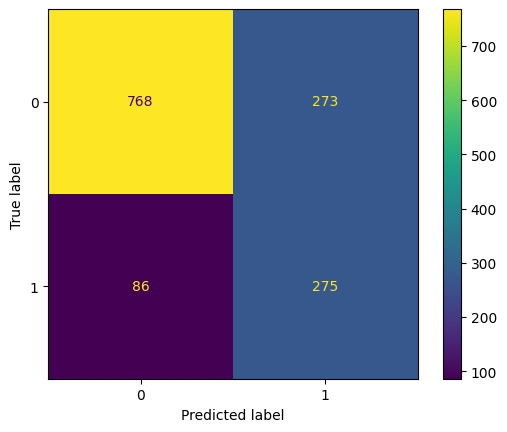

In [14]:
confusion_display = confusion(y_test=y_test, y_pred=xgb_test_pred)

### Save Model

In [15]:
from src.models import save_load_model

best_saved_model = save_load_model.save_model(final_model=xgb_best_model)